<h1><center> Классификация текстов с помощью модели BERT</center></h1>



На этом занятии мы вернемся к задаче классификации текстов.

В качестве данных будем использовать отзывы на приложения в Google Play.
Данные будут содержать тексты отзывов и оценки, которые пользователи поставили приложениям (от 1 до 5).

Наша задача -- построить модель, которая сможет предсказать оценку пользователя на основе текста его отзыва.

Для решения этой задачи мы будем использовать модель BERT, основанную на архитектуре Transformer.

Мы научимся:
- Обрабатывать данные для модели BERT
- Дообучать модель BERT на нашем наборе данных
- Использовать обученную модель для оценки текстов

## Загрузка данных

Мы будем использовать библиотеку [Transformers](https://huggingface.co/transformers/) от Hugging Face

In [1]:
!pip install -q -U watermark

In [2]:
!pip install -qq transformers

In [3]:
!pip install -q transformers[torch]

In [4]:
!pip install -q accelerate

In [5]:
!pip install -q datasets

In [34]:
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.6 MB/s eta 0:00:00


In [6]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers,accelerate,datasets

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.23.5
pandas      : 1.5.3
torch       : 2.1.0+cu118
transformers: 4.35.0
accelerate  : 0.24.1
datasets    : 2.14.6



In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

import torch

Загрузим набор данных, который мы будем использовать для обучения и тестирования модели -- отзывы на приложения в Google Play.


In [8]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 135MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 94.8MB/s]


In [9]:
df = pd.read_csv("reviews.csv")
print("Количество примеров: ", df.shape[0])
df.head()

Количество примеров:  15746


,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [10]:
df.shape

(15746, 11)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


Посмотрим на распределение классов в выборке

In [12]:
df.score.value_counts()

3    5042
5    2900
4    2776
1    2566
2    2462
Name: score, dtype: int64

Можно видеть, что данные несбалансированы.
Теперь приведем метки классов к другому виду -- разделим их на 3 класса: негативные, нейтральные и позитивные.

In [13]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 'negative'
  elif rating == 3:
    return 'neutral'
  else:
    return 'positive'

df['sentiment'] = df.score.apply(to_sentiment)

In [14]:
df.sentiment.value_counts()

positive    5676
neutral     5042
negative    5028
Name: sentiment, dtype: int64

В таком виде классы почти сбалансированы.

In [15]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df[['content', 'sentiment']])

train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

In [16]:
data = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [17]:
data

DatasetDict({
    train: Dataset({
        features: ['content', 'sentiment'],
        num_rows: 11809
    })
    test: Dataset({
        features: ['content', 'sentiment'],
        num_rows: 3937
    })
})

## Предобработка данных

Для обучение модели BERT нам нужно обработать исходный текст определенным образом:
* Добавить служебные символы для разделения предложений и классификации
* Привести все последовательности к единой длине (используя padding)
* Создать список (*attention mask*) из 0 и 1, в котором 0 будут соответствовать вспомогательным токенам (padding), а 1 $-$ настоящим.

Будем использовать модели токенизации из библиотеки Hugging Face.

In [18]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
#'bert-base-uncased'

Загрузим Tokenizer:

In [19]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Посмотрим, как работает модель токенизации для BERT.



In [ ]:
sample_txt = 'This app is really helpful, I use it to create watchlists ans organize stuff.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: This app is really helpful, I use it to create watchlists ans organize stuff.
   Tokens: ['this', 'app', 'is', 'really', 'helpful', ',', 'i', 'use', 'it', 'to', 'create', 'watch', '##lists', 'an', '##s', 'organize', 'stuff', '.']
Token IDs: [2023, 10439, 2003, 2428, 14044, 1010, 1045, 2224, 2009, 2000, 3443, 3422, 27103, 2019, 2015, 10939, 4933, 1012]



##  Специальные токены

`[SEP]` - метка конца предложения


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - чтобы использовать модель BERT для классификации, мы должны добавить этот токен в начало каждого предложения

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

Также существует специальный вспомогательный токен для выравнивания длин последовательностей

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

Кроме того, существует специальный токен для неизвестных слов, которые не встречались в обучающей выборке

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

Вся эта предобработка может быть сделана с помощью метода encode_pluse

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt.lower(),
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
)

encoding.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  2023, 10439,  2003,  2428, 14044,  1010,  1045,  2224,  2009,
         2000,  3443,  3422, 27103,  2019,  2015, 10939,  4933,  1012,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

Такая же длина будет и у *attention mask*

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

Вернемся к нашим данным:

In [20]:
def transform_labels(label):

    label = label['sentiment']
    num = 0
    if label == 'nositive':
        num = 0
    elif label == 'neutral':
        num = 1
    elif label == 'positive':
        num = 2

    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['content'], padding='max_length')

data = data.map(tokenize_data, batched=True)

data = data.map(transform_labels, remove_columns=['content', 'sentiment'])

Map:   0%|          | 0/11809 [00:00<?, ? examples/s]

Map:   0%|          | 0/3937 [00:00<?, ? examples/s]

Map:   0%|          | 0/11809 [00:00<?, ? examples/s]

Map:   0%|          | 0/3937 [00:00<?, ? examples/s]

Разобъем данные на train и val (тут мы также берем сабсемпл в целях экономии ресурсов):

In [21]:
train_data = data['train'].shuffle(seed=10).select(range(1000))
eval_data = data['train'].shuffle(seed=10).select(range(1000, 1200))

#del data

In [22]:
train_data

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})

## Обучение модели

Инициализируем модель:

In [23]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    num_labels=3
    )

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [121]:
#help(AutoModelForSequenceClassification.from_pretrained)

В целях экономии ресурсов мы возьмем маленький размер батча и пройдем всего 3 эпохи:

In [67]:
batch_size = 32

In [68]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_strategy="epoch", 
)

In [69]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_data,
    eval_dataset=eval_data,
    tokenizer=tokenizer,
)

In [70]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.025200,3.283047
2,0.028300,3.040118
3,0.012300,3.200227


TrainOutput(global_step=96, training_loss=0.021959373416999977, metrics={'train_runtime': 169.332, 'train_samples_per_second': 17.717, 'train_steps_per_second': 0.567, 'total_flos': 397409283072000.0, 'train_loss': 0.021959373416999977, 'epoch': 3.0})

In [71]:
trainer.evaluate()

{'eval_loss': 3.2002265453338623,
 'eval_runtime': 3.4962,
 'eval_samples_per_second': 57.205,
 'eval_steps_per_second': 2.002,
 'epoch': 3.0}

## Инференс модели

Соберем функцию для предсказания на произвольных текстах:

In [49]:
def compute_labels(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return predictions

In [73]:
text = "I'm really happy with this app, makes counting calories so easier"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

In [74]:
logits = outputs.logits
logits.shape

torch.Size([1, 3])

In [79]:
predictions = torch.argmax(logits, axis=-1)
predictions

tensor([2], device='cuda:0')

Посмотрим на результаты работы модели на тестовой выборке:

In [88]:
test_data = pd.read_csv('test.csv')
test_data

,content,sentiment
0,Like the look but it messes up straight away. ...,negative
1,"I tried many apps , but honestly this app is v...",positive
2,Can't post to my google calendar or any other ...,negative
3,Wow its used for my studies great please also ...,positive
4,Not Working On Xperia E1!,negative
...,...,...
3932,I loved this app. Worked so great I purchased ...,positive
3933,Thank you for responding and I'm looking forwa...,positive
3934,What appealed to me the most about this app wa...,negative
3935,"smooth interface, but i didnt see where i can ...",neutral


In [91]:
id_to_sent = {
    2: 'positive',
    1: 'neutral',
    0: 'negative'
}

def predict_sentiment(text, model=model, tokenizer=tokenizer, trainer=trainer, id_to_sent=id_to_sent):
  encoding = tokenizer(text, return_tensors="pt")
  encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

  outputs = trainer.model(**encoding)
  logits = outputs.logits
  pred = torch.argmax(logits, axis=-1)[0].item()
  sentiment = id_to_sent[pred]

  return sentiment

In [92]:
test_data['pred_sentiment'] = test_data['content'].map(predict_sentiment)

In [95]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test_data['sentiment'], test_data['pred_sentiment']))

              precision    recall  f1-score   support

    negative       0.70      0.62      0.66      1277
     neutral       0.50      0.60      0.54      1250
    positive       0.78      0.73      0.75      1410

    accuracy                           0.65      3937
   macro avg       0.66      0.65      0.65      3937
weighted avg       0.67      0.65      0.66      3937



Из данного отчета видно, что сложнее всего классифицировать нейтральные отзывы.

Посмотрим также на confusion matrix предсказаний модели на тестовой выборке.

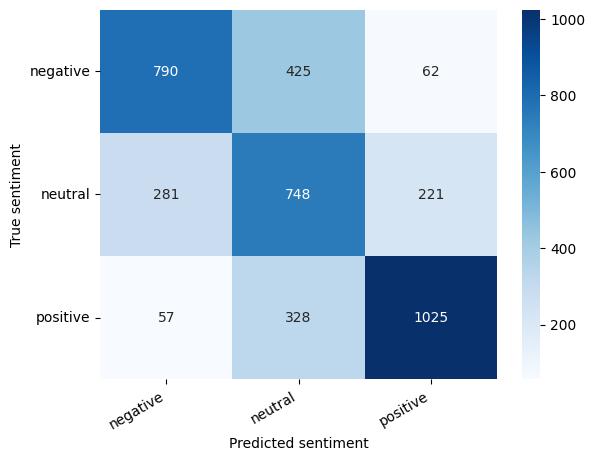

In [98]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

class_names = ['negative', 'neutral', 'positive']
cm = confusion_matrix(test_data['sentiment'], test_data['pred_sentiment'])
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Здесь также можно видеть, что модели сложнее всего классифицировать нейтральные отзывы.